In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, average_precision_score)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import xgboost as xgb
import lightgbm as lgb

import joblib

import warnings
warnings.filterwarnings('ignore')

In [26]:
data = pd.read_csv('fraud_oracle.csv')

In [27]:
data.isnull().values.any()

np.False_

## Checking for multicollinearity

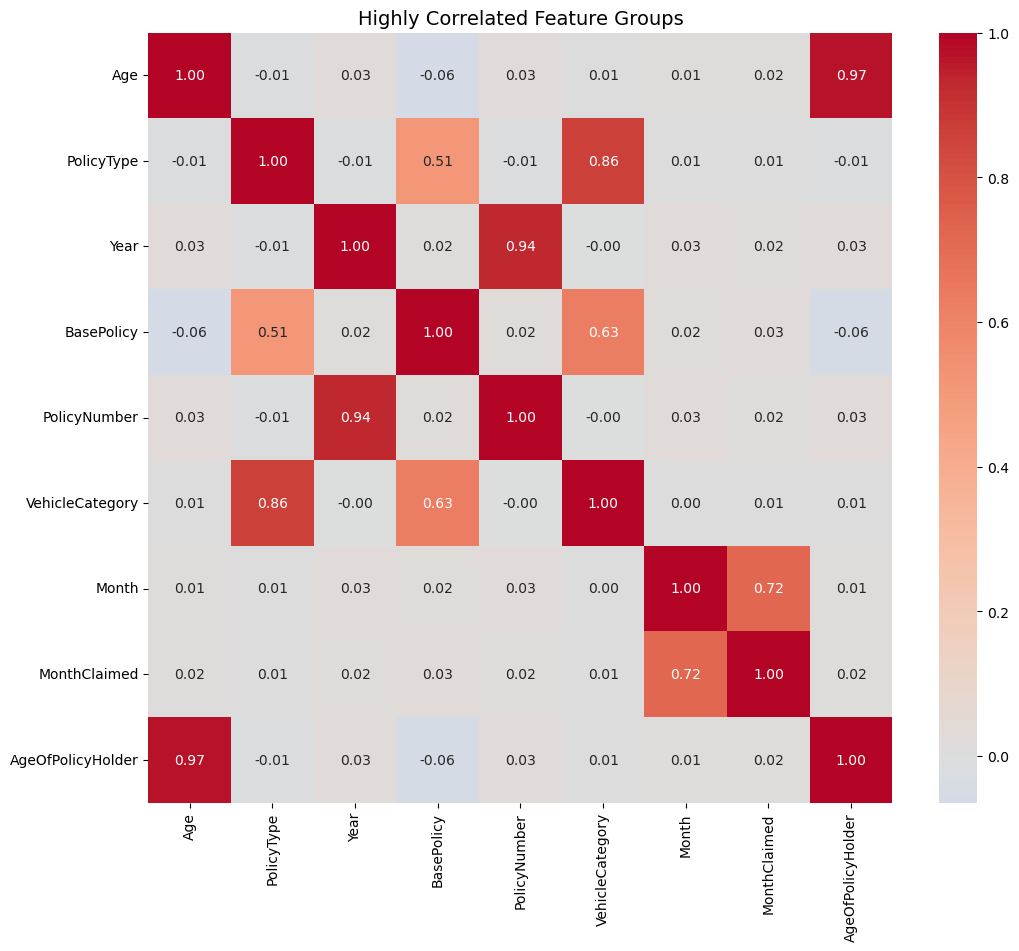

In [28]:
data_encoded = data.copy()

for col in data_encoded.select_dtypes(include=['object', 'category']):
    data_encoded[col] = LabelEncoder().fit_transform(data_encoded[col])

features_only = data_encoded.drop(columns=["FraudFound_P"])
corr_matrix = features_only.corr()

corr_pairs = (corr_matrix.abs().unstack().sort_values(ascending=False))

# Removing self-correlation
corr_pairs = corr_pairs[corr_pairs < 1.0]

# Only strong correlations
strong_corr = corr_pairs[corr_pairs >= 0.6]

high_corr_features = list(set([i for i, j in strong_corr.index] + [j for i, j in strong_corr.index]))

plt.figure(figsize=(12, 10))
sns.heatmap(features_only[high_corr_features].corr(), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Highly Correlated Feature Groups", fontsize=14)
plt.show()

## Feature Selection

In [29]:
drop_columns = ["PolicyNumber", "Year", "RepNumber", "NumberOfSuppliments", "BasePolicy", "VehicleCategory", "Age", "NumberOfSuppliments", "DayOfWeekClaimed", "WeekOfMonthClaimed", "MonthClaimed"]

data.drop(columns=drop_columns, inplace=True)

In [30]:
data.columns

Index(['Month', 'WeekOfMonth', 'DayOfWeek', 'Make', 'AccidentArea', 'Sex',
       'MaritalStatus', 'Fault', 'PolicyType', 'VehiclePrice', 'FraudFound_P',
       'Deductible', 'DriverRating', 'Days_Policy_Accident',
       'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
       'AgeOfPolicyHolder', 'PoliceReportFiled', 'WitnessPresent', 'AgentType',
       'AddressChange_Claim', 'NumberOfCars'],
      dtype='object')

## Train-Test Split

In [31]:
X = data.drop(columns='FraudFound_P', axis=1)
y = data['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(15420, 22) (12336, 22) (3084, 22)


## Data Preprocessing

In [32]:
# Encoding and Scaling
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing for numeric: center & scale
numeric_transformer = StandardScaler()
# Preprocessing for categorical: one-hot encoding
categorical_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

# Combining transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Fitting the preprocessor on training data
X_train_preprocessed = preprocessor.fit_transform(X_train)

# Transforming test data
X_test_processed = preprocessor.transform(X_test)

# Saving preprocessor
joblib.dump(preprocessor, 'data-preprocessor.pkl')

['data_preprocessor.pkl']


## Data Balancing using SMOTE

In [33]:
smote = SMOTE(sampling_strategy=0.5, random_state=123)
X_res, y_res = smote.fit_resample(X_train_preprocessed, y_train)

## Model Training

### Ensemble with Soft Voting

In [34]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
xgb_model = xgb.XGBClassifier(scale_pos_weight=10, random_state=42)
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)

ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('xgb', xgb_model), ('lgb', lgb_model)],
    voting='soft',
    weights=[2, 1, 1, 1]  # giving more weight to LR for higher recall
)

# Fitting the model
ensemble.fit(X_res, y_res)

[LightGBM] [Info] Number of positive: 5799, number of negative: 11598
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12353
[LightGBM] [Info] Number of data points in the train set: 17397, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 random_state=42)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categ...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('lgb',
                              LGBMClassifier(class_weight='balanced',
                                             random_state=42))],
                 voting='soft', weights=[2, 1, 1, 1])

### Model Evaluation

In [35]:
# Predictions
y_pred = ensemble.predict(X_test_processed)
y_pred_proba = ensemble.predict_proba(X_test_processed)[:, 1]  # probability of class 1 (fraud)

pr_auc = average_precision_score(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      2899
           1       0.17      0.30      0.21       185

    accuracy                           0.87      3084
   macro avg       0.56      0.60      0.57      3084
weighted avg       0.91      0.87      0.88      3084

Confusion Matrix:
 [[2617  282]
 [ 129   56]]
ROC-AUC: 0.7841
PR-AUC: 0.1772


In [36]:
# Saving the model
joblib.dump(ensemble, 'ensemble-model.pkl')

['ensemble_model.pkl']